# Ejercico 4

Entrena un modelo en Keras que combine capas GRU y convolucionales para predecir los valores de cierre de Amazon utilizando como entrada únicamente los valores de apertura de los datos Amazon de los 4 días anteriores y que obtenga unos resultados en test mejores que los del apartado anterior.

In [44]:
import yfinance as yf
import pandas as pd
import numpy as np

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv1D, Flatten, GRU
from tensorflow.keras import regularizers

In [46]:
amazon = yf.Ticker("AMZN")
amzn_df = amazon.history(period="max")

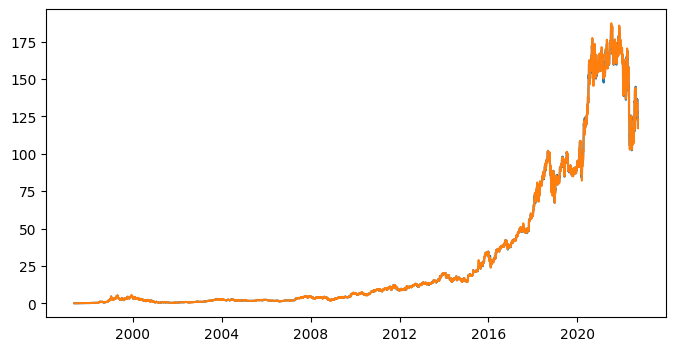

In [47]:
plt.figure(figsize=(8,4))
plt.plot(amzn_df.Close)
plt.plot(amzn_df.Open);


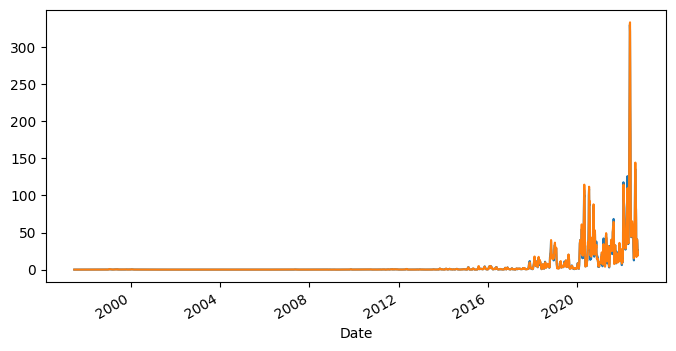

In [48]:
plt.figure(figsize=(8,4))
amzn_df.Close.rolling(window=22).var().plot()
amzn_df.Open.rolling(window=22).var().plot();

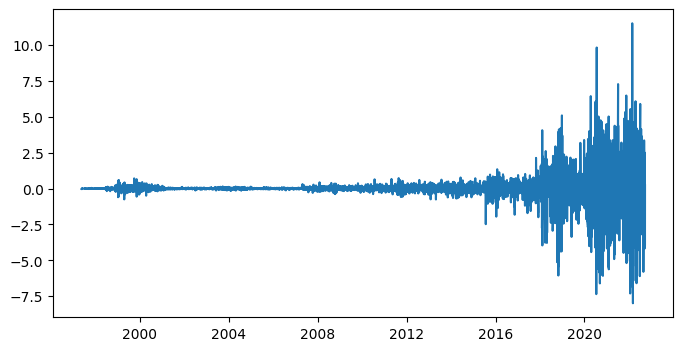

In [49]:
plt.figure(figsize=(8,4))
plt.plot(amzn_df.Close - amzn_df.Open);

In [50]:
batch_size = 4
n_valores = amzn_df.shape[0] -(amzn_df.shape[0]%batch_size)
X_train = amzn_df.iloc[:n_valores, :].Open.values.reshape(-1, batch_size, 1)
Y_train = amzn_df.iloc[:n_valores, :].Close.values[np.arange(3,n_valores,batch_size)]

In [51]:
X = amzn_df.iloc[:n_valores, :].Open.values.reshape(-1, batch_size, 1)
Y = amzn_df.iloc[:n_valores, :].Close.values[np.arange(3,n_valores,batch_size)]


In [52]:
umbral = int(len(X)*0.9)
X_train, X_test = X[:umbral], X[umbral:]
Y_train, Y_test = Y[:umbral], Y[umbral:]

### Modelo Lineal

In [53]:
model_lineal = Sequential(name='lineal')
model_lineal.add(Flatten(input_shape=(4,1)))
model_lineal.add(Dense(1))
model_lineal.summary()

Model: "lineal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 4)                 0         
                                                                 
 dense_27 (Dense)            (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [33]:
opt_adam = Adam(learning_rate = 5e-4)
model_lineal.compile(optimizer=opt_adam,
                   loss='mse',
                   metrics=['mae'])

In [34]:
history = model_lineal.fit(X_train,
                        Y_train,
                        validation_split = 0.2,
                        epochs=1000,
                        batch_size=128)

Epoch 1/1000
9/9 [==============================] - 1s 25ms/step - loss: 282.5396 - mae: 11.6613 - val_loss: 20635.8223 - val_mae: 133.1437
Epoch 2/1000
9/9 [==============================] - 0s 13ms/step - loss: 277.7971 - mae: 11.5610 - val_loss: 20300.6230 - val_mae: 132.0572
Epoch 3/1000
9/9 [==============================] - 0s 14ms/step - loss: 273.2055 - mae: 11.4627 - val_loss: 19964.6133 - val_mae: 130.9591
Epoch 4/1000
9/9 [==============================] - 0s 15ms/step - loss: 268.5279 - mae: 11.3623 - val_loss: 19635.3379 - val_mae: 129.8739
Epoch 5/1000
9/9 [==============================] - 0s 10ms/step - loss: 263.9115 - mae: 11.2630 - val_loss: 19309.7617 - val_mae: 128.7920
Epoch 6/1000
9/9 [==============================] - 0s 9ms/step - loss: 259.3875 - mae: 11.1642 - val_loss: 18985.7422 - val_mae: 127.7061
Epoch 7/1000
9/9 [==============================] - 0s 9ms/step - loss: 255.0361 - mae: 11.0660 - val_loss: 18658.8477 - val_mae: 126.6012
Epoch 8/1000
9/9 [====

In [36]:
score = model_lineal.evaluate(X_test, Y_test)
score

5/5 [==============================] - 0s 2ms/step - loss: 10.1044 - mae: 2.4744


[10.104436874389648, 2.4743812084198]

### Modelo incluyendo capas Conv1D, GRU y Dense

In [40]:
model_amzn = Sequential(name='amzn_gru_end')

model_amzn.add(Conv1D(128, 2,
                      padding='same',
                      input_shape=(4,1),
                      activity_regularizer=regularizers.l2(0.01)))
model_amzn.add(GRU(64, activation='relu'))
model_amzn.add(Dense(64, activation='relu'))
model_amzn.add(Dense(1))

model_amzn.summary()

Model: "amzn_gru_end"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 4, 128)            384       
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 41,857
Trainable params: 41,857
Non-trainable params: 0
_________________________________________________________________


In [84]:
model_amzn_gru_first = Sequential(name='amzn_gru_first')

model_amzn_gru_first.add(GRU(64, input_shape=(4,1),
                         activation='relu',
                         return_sequences=True))

model_amzn_gru_first.add(Conv1D(256, 2,
                      padding='same'))


model_amzn_gru_first.add(Flatten())
model_amzn_gru_first.add(Dense(64, activation='relu'))
model_amzn_gru_first.add(Dense(1))

model_amzn_gru_first.summary()

Model: "amzn_gru_first"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_26 (GRU)                (None, 4, 64)             12864     
                                                                 
 conv1d_28 (Conv1D)          (None, 4, 256)            33024     
                                                                 
 flatten_12 (Flatten)        (None, 1024)              0         
                                                                 
 dense_44 (Dense)            (None, 64)                65600     
                                                                 
 dense_45 (Dense)            (None, 1)                 65        
                                                                 
Total params: 111,553
Trainable params: 111,553
Non-trainable params: 0
_________________________________________________________________


In [85]:
opt_adam = Adam(learning_rate = 5e-4)
model_amzn_gru_first.compile(optimizer=opt_adam,
                            loss='mse',
                            metrics=['mae'])

In [86]:
history = model_amzn_gru_first.fit(X_train,
                        Y_train,
                        validation_split = 0.2,
                        epochs=1000,
                        batch_size=128)

Epoch 1/1000
9/9 [==============================] - 3s 60ms/step - loss: 32.4083 - mae: 3.7897 - val_loss: 802.6313 - val_mae: 26.0459
Epoch 2/1000
9/9 [==============================] - 0s 28ms/step - loss: 2.2623 - mae: 0.9191 - val_loss: 47.2451 - val_mae: 6.5874
Epoch 3/1000
9/9 [==============================] - 0s 24ms/step - loss: 2.5725 - mae: 1.1958 - val_loss: 28.8967 - val_mae: 4.4096
Epoch 4/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.4895 - mae: 0.4047 - val_loss: 164.9396 - val_mae: 11.5664
Epoch 5/1000
9/9 [==============================] - 0s 34ms/step - loss: 0.3591 - mae: 0.3385 - val_loss: 35.1101 - val_mae: 4.9940
Epoch 6/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.1581 - mae: 0.3062 - val_loss: 15.1479 - val_mae: 3.0288
Epoch 7/1000
9/9 [==============================] - 0s 30ms/step - loss: 0.0853 - mae: 0.2015 - val_loss: 48.8634 - val_mae: 6.0379
Epoch 8/1000
9/9 [==============================] - 0s 27ms/step - loss

In [87]:
score_first = model_amzn_gru_first.evaluate(X_test, Y_test)
score_first

5/5 [==============================] - 0s 2ms/step - loss: 22.9184 - mae: 4.1725


[22.91836929321289, 4.172534942626953]

In [75]:
model_amzn_gru_last = Sequential(name='amzn_gru_last')


model_amzn_gru_last.add(Conv1D(128, 2,
                        input_shape=(4,1),
                        padding='same',
                        activity_regularizer=regularizers.l2(0.01)))

model_amzn_gru_last.add(GRU(64,
                         activation='relu'))

model_amzn_gru_last.add(Dense(64, activation='relu'))
model_amzn_gru_last.add(Dense(1))

model_amzn_gru_last.summary()

Model: "amzn_gru_last"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 4, 128)            384       
                                                                 
 gru_22 (GRU)                (None, 64)                37248     
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 41,857
Trainable params: 41,857
Non-trainable params: 0
_________________________________________________________________


In [76]:
opt_adam = Adam(learning_rate = 5e-4)
model_amzn_gru_last.compile(optimizer=opt_adam,
                            loss='mse',
                            metrics=['mae'])

In [77]:
history_last = model_amzn_gru_last.fit(X_train,
                                       Y_train,
                                        validation_split = 0.2,
                                        epochs=1000,
                                        batch_size=128)

Epoch 1/1000
9/9 [==============================] - 3s 82ms/step - loss: 62.8739 - mae: 5.2980 - val_loss: 3934.4805 - val_mae: 55.8885
Epoch 2/1000
9/9 [==============================] - 0s 31ms/step - loss: 41.5288 - mae: 4.2239 - val_loss: 2139.2668 - val_mae: 39.9165
Epoch 3/1000
9/9 [==============================] - 0s 34ms/step - loss: 20.2167 - mae: 2.7140 - val_loss: 651.8519 - val_mae: 17.5471
Epoch 4/1000
9/9 [==============================] - 0s 30ms/step - loss: 5.6380 - mae: 0.7482 - val_loss: 474.6470 - val_mae: 12.2488
Epoch 5/1000
9/9 [==============================] - 0s 27ms/step - loss: 5.4628 - mae: 0.7314 - val_loss: 353.6060 - val_mae: 6.8485
Epoch 6/1000
9/9 [==============================] - 0s 22ms/step - loss: 4.0981 - mae: 0.3002 - val_loss: 427.3230 - val_mae: 10.9067
Epoch 7/1000
9/9 [==============================] - 0s 28ms/step - loss: 3.8286 - mae: 0.2162 - val_loss: 286.2183 - val_mae: 3.3021
Epoch 8/1000
9/9 [==============================] - 0s 26ms

In [78]:
score_last = model_amzn_gru_last.evaluate(X_test, Y_test)
score_last

5/5 [==============================] - 0s 3ms/step - loss: 44.1914 - mae: 5.1954


[44.19142532348633, 5.1954240798950195]

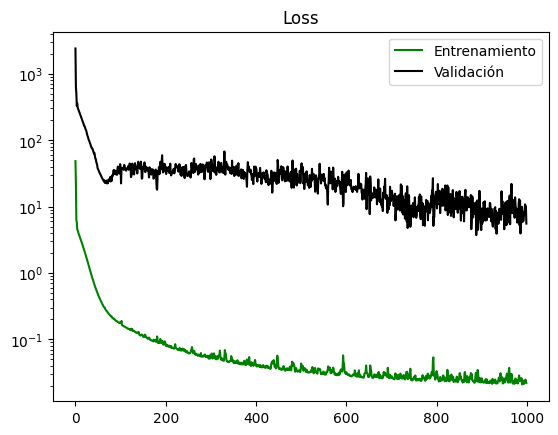

In [20]:
plt.title("Loss")
plt.plot(history.history['loss'],
         color='green',
         label="Entrenamiento")
plt.plot(history.history['val_loss'],
         color='black',
         label="Validación")
plt.legend()
plt.yscale("log")

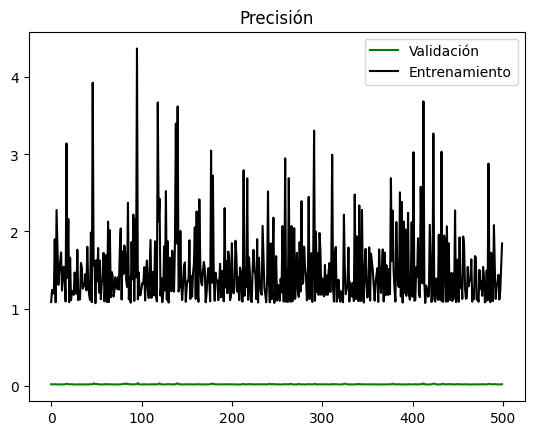

In [49]:
plt.title("Precisión")
plt.plot(history.history['mse'],
         color='green',
         label="Validación")
plt.plot(history.history['val_mse'],
         color='black',
         label="Entrenamiento")
plt.legend()

In [66]:
score = model_amzn_gru_first.evaluate(X_test, Y_test)
score

5/5 [==============================] - 0s 3ms/step - loss: 32.0755 - mae: 3.8162


[32.075496673583984, 3.8162364959716797]

In [54]:
y_hat = model_amzn.predict(X_test)

5/5 [==============================] - 0s 3ms/step


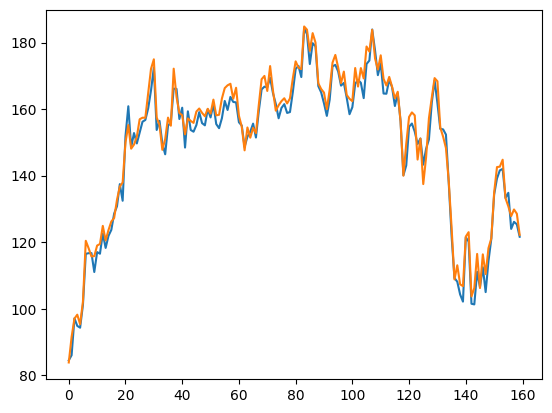

In [57]:
plt.plot(y_hat)
plt.plot(Y_test)